In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import knn_graph

import random
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from torch_geometric.nn import MessagePassing
from torch_geometric.nn.norm import BatchNorm

import torch.nn as nn
import matplotlib.pyplot as plt
import networkx as nx
from torch.nn import BCEWithLogitsLoss

In [87]:
num_samples = 5000
batch_size = 256
num_epochs = 10

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Preparation

In [5]:
def parse_tsp_line(line):
    # Split the line into parts
    parts = line.strip().split()
    
    # Extract coordinates
    coord_count = parts.index('output')
    coordinates = torch.tensor(list(map(float, parts[:coord_count]))).view(-1, 2)  # Shape (n, 2)
    
    # Extract tour, excluding the last repeated node
    tour = list(map(int, parts[coord_count + 1:-1]))  # Exclude the last node
    
    # Generate edge index for the tour
    edge_index = []
    for i in range(len(tour) - 1):
        edge_index.append((tour[i] - 1, tour[i + 1] - 1))  # Convert to 0-indexed
    edge_index.append((tour[-1] - 1, tour[0] - 1))  # Close the loop
    edge_index = torch.tensor(edge_index).t()  # Shape (2, n_edges)
    
    return coordinates, edge_index

# Example usage
line = "0.1 0.2 0.3 0.4 0.5 0.6 output 2 3 1 2"
coordinates, edge_index = parse_tsp_line(line)
print("Coordinates:", coordinates)
print("Edge Index:", edge_index)


Coordinates: tensor([[0.1000, 0.2000],
        [0.3000, 0.4000],
        [0.5000, 0.6000]])
Edge Index: tensor([[1, 2, 0],
        [2, 0, 1]])


In [6]:
def load_tsp_data(file_path):
    graphs = []
    with open(file_path, 'r') as f:
        for line in f:
            coordinates, edge_index = parse_tsp_line(line)
            graphs.append((coordinates, edge_index))
    return graphs

In [7]:
def sample_data_as_data_objects(file_path, num_samples):
    """
    Samples data from a file and converts it into a list of PyTorch Geometric Data objects.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    sampled_lines = random.sample(lines, num_samples)
    data_list = []
    
    for line in sampled_lines:
        coordinates, edge_index = parse_tsp_line(line)
        
        # Compute edge attributes (e.g., distances)
        edge_attr = torch.norm(
            coordinates[edge_index[0]] - coordinates[edge_index[1]], dim=1
        )
        
        # Create a Data object
        graph = Data(x=coordinates, edge_index=edge_index, edge_attr=edge_attr)
        data_list.append(graph)
    
    return data_list

In [88]:
# Path to the dataset file
file_path = 'tsp_data/combined_train.txt'
# Sample data and create Data objects
data_list = sample_data_as_data_objects(file_path, num_samples)
# Create a DataLoader
loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

In [48]:
for batch in loader:
    print("Batch Node Features Shape:", batch.x.shape)  # Node features for all graphs
    print("Batch Edge Index Shape:", batch.edge_index.shape)  # Combined edge indices
    print("Batch Edge Attributes Shape:", batch.edge_attr.shape)  # Edge distances
    print("Batch Graph Membership:", batch.batch)  # Graph IDs for nodes

Batch Node Features Shape: torch.Size([30, 2])
Batch Edge Index Shape: torch.Size([2, 30])
Batch Edge Attributes Shape: torch.Size([30])
Batch Graph Membership: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])
Batch Node Features Shape: torch.Size([10, 2])
Batch Edge Index Shape: torch.Size([2, 10])
Batch Edge Attributes Shape: torch.Size([10])
Batch Graph Membership: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Batch Node Features Shape: torch.Size([30, 2])
Batch Edge Index Shape: torch.Size([2, 30])
Batch Edge Attributes Shape: torch.Size([30])
Batch Graph Membership: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])
Batch Node Features Shape: torch.Size([10, 2])
Batch Edge Index Shape: torch.Size([2, 10])
Batch Edge Attributes Shape: torch.Size([10])
Batch Graph Membership: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Batch Node Features Shape: torch.Size([30, 2])
Batch Edge Index 

# Model Layers

### Input Layer

In [10]:
class TSPInputLayer(torch.nn.Module):
    def __init__(self, input_dim=2, output_dim=16, k=5):
        """
        Initialize the TSP input layer.
        :param input_dim: Dimension of input node features (2D coordinates).
        :param output_dim: Dimension of embedded node features (d).
        :param k: Number of nearest neighbors for graph construction.
        """
        super(TSPInputLayer, self).__init__()
        self.k = k
        self.node_embed = torch.nn.Linear(input_dim, output_dim)  # Embedding nodes
        self.edge_embed_1 = torch.nn.Linear(1, output_dim // 2)   # A2 for embedding edge distances
        self.edge_embed_2 = torch.nn.Linear(3, output_dim // 2)   # A3 for embedding edge indicators
    
    def forward(self, x, batch=None):
        """
        Forward pass of the TSP input layer.
        :param x: Node coordinates (n, 2).
        :param batch: Batch vector for mini-batch graph processing.
        :return: Node and edge embeddings.
        """
        # Node embedding
        node_features = self.node_embed(x)  # L_i = A_1 x_i + b_1

        # Build k-NN graph
        edge_index = knn_graph(x, k=self.k, batch=batch, loop=True).to(device)

        # Compute edge features
        row, col = edge_index
        edge_distances = torch.norm(x[row] - x[col], dim=1, keepdim=True).to(device)  # Distance between nodes
        edge_indicator = torch.cat([
            (row == col).float().unsqueeze(1),  # Self-loop indicator
            torch.ones((edge_index.size(1), 1), device=device),  # k-NN indicator
            torch.zeros((edge_index.size(1), 1), device=device)  # Padding (can modify based on needs)
        ], dim=1)
        
        # Embed edge features
        edge_features = torch.cat([
            self.edge_embed_1(edge_distances),
            self.edge_embed_2(edge_indicator)
        ], dim=1)

        return node_features, edge_index, edge_features


### GraphSage and GCN Layer

In [11]:
class CustomGCNLayer(MessagePassing):
    def __init__(self, input_dim, output_dim):
        super(CustomGCNLayer, self).__init__(aggr='add')  # Aggregate by summation
        
        # Learnable weight matrices
        self.W1 = torch.nn.Parameter(torch.Tensor(output_dim, input_dim))
        self.W2 = torch.nn.Parameter(torch.Tensor(output_dim, input_dim))
        self.W3 = torch.nn.Parameter(torch.Tensor(output_dim, input_dim))
        self.W4 = torch.nn.Parameter(torch.Tensor(output_dim, input_dim))
        self.W5 = torch.nn.Parameter(torch.Tensor(output_dim, input_dim))
        
        # Batch normalization
        self.bn_node = BatchNorm(output_dim)
        self.bn_edge = BatchNorm(output_dim)
        
        # Initialization
        self.reset_parameters()
    
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.W1)
        torch.nn.init.xavier_uniform_(self.W2)
        torch.nn.init.xavier_uniform_(self.W3)
        torch.nn.init.xavier_uniform_(self.W4)
        torch.nn.init.xavier_uniform_(self.W5)
    
    def forward(self, x, edge_index, edge_attr):
        """
        x: Node features [num_nodes, input_dim]
        edge_index: Edge indices [2, num_edges]
        edge_attr: Edge features [num_edges, input_dim]
        """
        # Update edge features
        edge_attr = self.update_edge_features(x, edge_index, edge_attr)
        
        # Update node features
        x = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        
        return x, edge_attr
    
    def update_edge_features(self, x, edge_index, edge_attr):
        row, col = edge_index  # Extract source and target nodes
        # Update edge features
        e_next = F.relu(self.bn_edge(
            torch.mm(edge_attr, self.W3.T) +  # [330, output_dim]
            torch.mm(x[row], self.W4.T) +    # [330, output_dim]
            torch.mm(x[col], self.W5.T)      # [330, output_dim]
        ))
        return e_next

    
    def message(self, x_j, edge_attr):
        """
        Compute messages for node updates.
        x_j: Features of neighboring nodes
        edge_attr: Features of corresponding edges
        """
        # Compute attention scores (Eq. 5)
        alpha = torch.sigmoid(edge_attr)
        alpha = alpha / (alpha.sum(dim=1, keepdim=True) + 1e-8)
        
        # Message = attention-weighted neighbor features
        return alpha * torch.mm(x_j, self.W2.T)
    
    def update(self, aggr_out, x):
        """
        Update node features (Eq. 4)
        aggr_out: Aggregated messages from neighbors
        x: Current node features
        """
        # Update node features
        n_next = F.relu(self.bn_node(
            torch.mm(x, self.W1.T) + aggr_out
        ))
        return n_next


### MLP Layer

In [12]:
class MLPClassifierLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2, num_layers=5):
        """
        Initialize the MLP Classifier Layer.
        :param input_dim: Dimension of node features (h_i, h_j).
        :param hidden_dim: Hidden dimension for the MLP.
        :param output_dim: Number of classes (default: 2 for binary classification).
        :param num_layers: Number of fully connected layers in the MLP.
        """
        super(MLPClassifierLayer, self).__init__()
        
        layers = []
        layers.append(nn.Linear(2 * input_dim, hidden_dim))  # First layer
        layers.append(nn.ReLU())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))  # Hidden layers
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, output_dim))  # Output layer

        self.mlp = nn.Sequential(*layers)

    def forward(self, node_features, edge_index):
        """
        Forward pass of the MLP Classifier Layer.
        :param node_features: Node features [num_nodes, input_dim].
        :param edge_index: Edge indices [2, num_edges].
        :return: Edge predictions [num_edges, output_dim].
        """
        # Extract node features for source and target nodes
        row, col = edge_index
        h_i = node_features[row]
        h_j = node_features[col]

        # Concatenate node features for each edge
        edge_features = torch.cat([h_i, h_j], dim=1)

        # Apply the MLP
        logits = self.mlp(edge_features)
        return logits


# Model Definition

In [13]:
class TSPModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=512, mlp_hidden_dim=256, output_dim=2, k=16, num_gcn_layers=1, num_mlp=1):
        """
        Initialize the TSP Model.
        :param input_dim: Dimension of input node features (coordinates).
        :param hidden_dim: Dimension of hidden node and edge features.
        :param mlp_hidden_dim: Hidden dimension for the MLP classifier.
        :param output_dim: Number of output classes (default: 2 for binary classification).
        :param k: Number of nearest neighbors for graph construction.
        :param num_gcn_layers: Number of graph convolutional layers.
        """
        super(TSPModel, self).__init__()
        self.input_layer = TSPInputLayer(input_dim=input_dim, output_dim=hidden_dim, k=k)
        self.gcn_layers = nn.ModuleList([CustomGCNLayer(input_dim=hidden_dim, output_dim=hidden_dim) for _ in range(num_gcn_layers)])
        self.mlp_classifier = MLPClassifierLayer(input_dim=hidden_dim, hidden_dim=mlp_hidden_dim, output_dim=output_dim, num_layers=num_mlp)

    def forward(self, x, batch=None):
        """
        Forward pass of the TSP Model.
        :param x: Node features (coordinates) of shape [num_nodes, input_dim].
        :param batch: Optional batch vector for mini-batch graph processing.
        :return: Logits and edge indices.
        """
        # Input Layer
        node_features, edge_index_knn, edge_features = self.input_layer(x, batch)

        # GCN Layers
        for gcn_layer in self.gcn_layers:
            node_features, edge_features = gcn_layer(node_features, edge_index_knn, edge_features)

        # MLP Classifier Layer
        logits = self.mlp_classifier(node_features, edge_index_knn)

        return logits, edge_index_knn

### Training Loop

In [118]:
# Model parameters
input_dim = 2  # Node coordinates are 2D
hidden_dim = 64
mlp_hidden_dim = 32  # Hidden dimension for MLP
gcn_l = 10
mlp_l = 3
output_dim = 2  # Binary classification (edge in TSP tour or not)
k = 4  # Number of nearest neighbors

# Instantiate the model and move to device
model = TSPModel(input_dim=input_dim, hidden_dim=hidden_dim, mlp_hidden_dim=mlp_hidden_dim, output_dim=output_dim, k=k, num_gcn_layers=gcn_l, num_mlp=mlp_l)
model = model.to(device)  # Move model to GPU

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(num_epochs):  # Number of epochs
    total_loss = 0.0

    for batch in loader:  # Assuming `loader` is your DataLoader
        # Extract data from the batch and move to device
        coordinates = batch.x.to(device)  # Node features (coordinates)
        edge_index_model = batch.edge_index.to(device)  # Optimal tour edges (ground truth)

        # Forward pass
        logits, edge_index_knn = model(coordinates)

        # Create ground truth labels
        num_edges_knn = edge_index_knn.size(1)
        labels = torch.zeros(num_edges_knn, dtype=torch.float, device=device)  # Use `device` explicitly

        # Convert edge indices to sets of tuples for fast lookup
        ground_truth_edges = {tuple(edge.tolist()) for edge in edge_index_model.t()}  # Convert to tuples
        knn_edges = [tuple(edge.tolist()) for edge in edge_index_knn.t()]  # Convert to tuples

        # Mark edges in the optimal tour as `1`
        for j, edge in enumerate(knn_edges):
            # Check both directions of the edge
            if edge in ground_truth_edges or (edge[1], edge[0]) in ground_truth_edges:
                labels[j] = 1.0

        # Compute loss
        loss = loss_fn(logits[:, 1], labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

# Save the entire model
torch.save(model, 'tsp_model.pth')

Epoch 1, Loss: 11.2211
Epoch 2, Loss: 3.2646
Epoch 3, Loss: 0.6938
Epoch 4, Loss: 0.6617
Epoch 5, Loss: 0.6590
Epoch 6, Loss: 0.6346
Epoch 7, Loss: 0.6327
Epoch 8, Loss: 0.6201
Epoch 9, Loss: 0.6448
Epoch 10, Loss: 0.6355


### Testing and Visualization

In [90]:
def validate_and_construct_tour(edges, num_nodes):
    edges_list = edges.t().tolist()
    print(edges_list)
    # Remove duplicate edges and ensure correct ordering (u, v) with u < v
    edges_cleaned = edges_list #list(set(map(tuple, (min(u, v), max(u, v)) for u, v in edges_list)))
    
    # Create a NetworkX graph
    graph = nx.Graph()
    graph.add_edges_from(edges_cleaned)
    
    # Ensure graph has all nodes (in case some are isolated)
    graph.add_nodes_from(range(num_nodes))
    
    #nx.draw(graph)
    if nx.is_connected(graph):
        # Use a greedy Hamiltonian cycle heuristic
        start_node = 0  # Start from node 0
        tour = [start_node]
        visited = set(tour)
        
        current_node = start_node
        while len(visited) < num_nodes:
            neighbors = list(graph.neighbors(current_node))
            # Select the first unvisited neighbor
            next_node = next((n for n in neighbors if n not in visited), None)
            if next_node is None:
                raise ValueError("Cannot find a Hamiltonian cycle: Graph is not dense enough.")
            tour.append(next_node)
            visited.add(next_node)
            current_node = next_node
        
        # Close the cycle
        tour.append(start_node)
        
        # Convert to list of edges
        tour_edges = [(tour[i], tour[i + 1]) for i in range(len(tour) - 1)]
        return torch.tensor(tour_edges)
    else:
        raise ValueError("The graph is not connected, so a Hamiltonian cycle is impossible.")


def visualize_tour(city_coordinates, tour_edges):
    # Create a plot of the tour
    plt.figure(figsize=(8, 8))
    plt.scatter(city_coordinates[:, 0], city_coordinates[:, 1], color='blue', s=100, label='Cities')
    
    # Draw the edges of the tour
    for i, j in tour_edges:
        plt.plot([city_coordinates[i, 0], city_coordinates[j, 0]],
                 [city_coordinates[i, 1], city_coordinates[j, 1]], color='red')
    
    # Annotate cities with numbers
    for idx, (x, y) in enumerate(city_coordinates):
        plt.text(x, y, str(idx), fontsize=12, ha='right')
    
    plt.title("Predicted TSP Tour")
    plt.legend()
    plt.show()

In [ ]:
# Load the saved model
loaded_model = torch.load('tsp_model.pth')
loaded_model = loaded_model.to(device)  # Move to the appropriate device if needed

Batch tensor: tensor([  0,   0,   0,  ..., 255, 255, 255])
Coordinates shape (total nodes in batch): torch.Size([5880, 2])
First graph coordinates shape: torch.Size([10, 2])
First graph edge index shape: torch.Size([2, 10])
Predicted Edges (First Graph): tensor([[0, 5, 6, 2, 1, 3, 2, 7, 2, 6, 0, 4, 3, 1, 2, 7, 4, 2, 6, 9, 5, 0, 6, 9,
         6, 9, 5, 0, 7, 8, 3, 1, 8, 7, 1, 3, 9, 6, 5, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5,
         6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9]])
Edge Probabilities (First Graph): tensor([0.0021, 0.0023, 0.0019, 0.0016, 0.0015, 0.0014, 0.0017, 0.0017, 0.0016,
        0.0019, 0.0020, 0.0021, 0.0015, 0.0015, 0.0017, 0.0018, 0.0024, 0.0018,
        0.0021, 0.0022, 0.0024, 0.0022, 0.0020, 0.0021, 0.0016, 0.0017, 0.0019,
        0.0017, 0.0020, 0.0032, 0.0017, 0.0017, 0.0047, 0.0029, 0.0025, 0.0024,
        0.0017, 0.0016, 0.0019, 0.0017])
Constructing tour...
[[0, 0], [5, 0], [6, 0], [2, 0], [1, 1], [3, 1], [

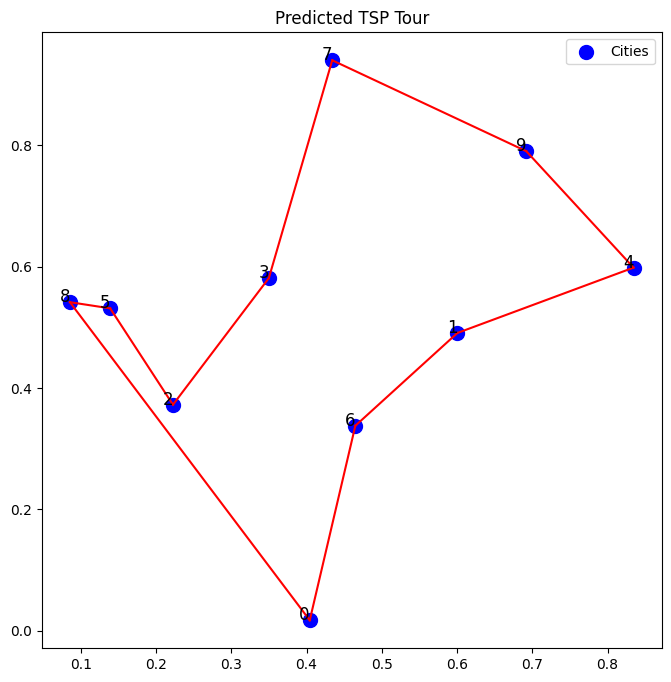

In [119]:
# Take one batch from the DataLoader
solved = True
while solved:
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Get a batch from the DataLoader
        batch = next(iter(loader))

        # Extract data from the batched graph
        batch_graph = batch  # A batched graph from the DataLoader
        print("Batch tensor:", batch_graph.batch)  # Indicates graph indices for each node
        print("Coordinates shape (total nodes in batch):", batch_graph.x.shape)

        # Ensure all graph data is moved to the same device as the model
        batch_graph = batch_graph.to(device)

        # Extract the first graph in the batch
        first_graph_mask = (batch_graph.batch == 0)  # Nodes belonging to the first graph
        coordinates = batch_graph.x[first_graph_mask]  # Extract node features for the first graph

        # Extract edges for the first graph
        edge_mask = (batch_graph.batch[batch_graph.edge_index[0]] == 0) & \
                    (batch_graph.batch[batch_graph.edge_index[1]] == 0)  # Both nodes in the same graph
        edge_index_model = batch_graph.edge_index[:, edge_mask]  # Edges belonging to the first graph

        print("First graph coordinates shape:", coordinates.shape)
        print("First graph edge index shape:", edge_index_model.shape)

        # Forward pass
        logits, edge_index_knn = model(coordinates)

        # Ensure edge_index_knn is moved to the same device as batch_graph
        edge_index_knn = edge_index_knn.to(device)

        # Filter predictions for the first graph
        # Find edges in the k-NN graph that belong to the first graph
        knn_edge_mask = (batch_graph.batch[edge_index_knn[0]] == 0) & \
                        (batch_graph.batch[edge_index_knn[1]] == 0)
        edge_index_knn_first = edge_index_knn[:, knn_edge_mask]  # Edges belonging to the first graph
        logits_first = logits[knn_edge_mask]  # Corresponding logits for these edges

        # Compute edge probabilities
        edge_probs_first = F.softmax(logits_first, dim=1)[:, 1]  # Probabilities for class 1 (TSP tour)

        # Move predictions to CPU
        logits_first = logits_first.cpu()
        edge_probs_first = edge_probs_first.cpu()
        edge_index_knn_first = edge_index_knn_first.cpu()

        # Threshold to filter predicted edges
        threshold = 0.001  # Adjust threshold as needed
        mask = edge_probs_first > threshold
        edge_predictions_first = edge_index_knn_first[:, mask]  # Filtered edges for the first graph

        # Print results
        print("Predicted Edges (First Graph):", edge_predictions_first)
        print("Edge Probabilities (First Graph):", edge_probs_first)

        # Visualize the predicted tour (optional)
        city_coordinates = coordinates.cpu().numpy()  # Convert to numpy
        try:
            # Validate and construct a tour if necessary
            num_nodes = city_coordinates.shape[0]
            print("Constructing tour...")
            tour_edges = validate_and_construct_tour(edge_predictions_first, num_nodes)
            print("Visualizing tour...")
            # Visualize the tour
            visualize_tour(city_coordinates, tour_edges)
            solved = False
        except ValueError as e:
            print(f"Error in constructing tour: {e}")

# Testing

In [65]:
def calculate_tour_length(coordinates, edge_index):
    """
    Calculates the total length of a tour given node coordinates and an edge index.
    :param coordinates: Tensor of shape [num_nodes, 2], representing the coordinates of each node.
    :param edge_index: Tensor of shape [2, num_edges], representing the edges in the tour.
    :return: The total length of the tour.
    """
    edge_coords = coordinates[edge_index]  # Get the coordinates of the edge endpoints
    distances = torch.norm(edge_coords[0] - edge_coords[1], dim=1)  # Calculate the Euclidean distance for each edge
    return distances.sum().item()  # Return the total tour length


In [126]:
# Path to the test dataset file
test_file_path = 'tsp_data/combined_test.txt'
num_test = 1000
# Sample data and create Data objects for test data
test_data_list = sample_data_as_data_objects(test_file_path, num_test)

# Create a DataLoader for the test data
test_loader = DataLoader(test_data_list, batch_size=1, shuffle=False)  # Use batch_size=1 for evaluation


In [121]:
model.eval()  # Set the model to evaluation mode
total_relative_error = 0.0
num_samples = 0

with torch.no_grad():
    for batch in test_loader:
        # Extract data from the batch
        batch_graph = batch.to(device)
        coordinates = batch_graph.x
        edge_index_optimal = batch_graph.edge_index

        # Forward pass
        logits, edge_index_knn = model(coordinates)

        # Compute edge probabilities
        edge_probs = F.softmax(logits, dim=1)[:, 1]  # Probabilities for class 1 (TSP tour)

        # Threshold to filter predicted edges
        threshold = 0.001
        mask = edge_probs > threshold
        edge_predictions = edge_index_knn[:, mask]

        # Validate the predicted tour
        city_coordinates = coordinates.cpu().numpy()
        try:
            num_nodes = city_coordinates.shape[0]
            tour_edges_predicted = validate_and_construct_tour(edge_predictions, num_nodes)
            
            # Calculate optimal and predicted tour lengths
            optimal_length = calculate_tour_length(coordinates, edge_index_optimal)
            predicted_length = calculate_tour_length(coordinates, tour_edges_predicted)
            
            # Compute relative error
            relative_error = abs(predicted_length - optimal_length) / optimal_length
            total_relative_error += relative_error
            num_samples += 1

            # Print results for this sample
            print(f"Sample {num_samples}:")
            print(f"Optimal Length: {optimal_length:.2f}, Predicted Length: {predicted_length:.2f}")
            print(f"Relative Error: {relative_error:.4f}")
        
        except ValueError as e:
            # Skip this graph if a valid tour could not be constructed
            print(f"Skipping graph due to error in constructing tour: {e}")
            continue

# Compute average relative error across all samples
average_relative_error = total_relative_error / num_samples if num_samples > 0 else float('inf')
print(f"Average Relative Error: {average_relative_error:.4f}")


[[5, 0], [6, 0], [12, 0], [1, 1], [22, 1], [10, 1], [9, 1], [2, 2], [19, 2], [25, 2], [3, 2], [3, 3], [19, 3], [29, 3], [23, 3], [4, 4], [29, 4], [23, 4], [15, 4], [5, 5], [6, 5], [13, 5], [0, 5], [6, 6], [13, 6], [5, 6], [0, 6], [7, 7], [24, 7], [14, 7], [26, 7], [8, 8], [25, 8], [27, 8], [17, 8], [9, 9], [22, 9], [1, 9], [10, 9], [10, 10], [22, 10], [1, 10], [9, 10], [11, 11], [16, 11], [14, 11], [26, 11], [12, 12], [5, 12], [18, 12], [0, 12], [13, 13], [6, 13], [5, 13], [18, 13], [14, 14], [26, 14], [7, 14], [24, 14], [15, 15], [21, 15], [4, 15], [6, 15], [16, 16], [11, 16], [26, 16], [14, 16], [17, 17], [27, 17], [8, 17], [25, 17], [18, 18], [13, 18], [20, 18], [5, 18], [19, 19], [3, 19], [29, 19], [23, 19], [20, 20], [28, 20], [18, 20], [13, 20], [21, 21], [15, 21], [28, 21], [13, 21], [22, 22], [10, 22], [1, 22], [9, 22], [23, 23], [29, 23], [3, 23], [19, 23], [24, 24], [7, 24], [14, 24], [26, 24], [25, 25], [8, 25], [27, 25], [17, 25], [26, 26], [14, 26], [24, 26], [11, 26], [27

[[0, 0], [5, 0], [6, 0], [12, 0], [1, 1], [22, 1], [10, 1], [9, 1], [2, 2], [19, 2], [25, 2], [3, 2], [3, 3], [19, 3], [29, 3], [23, 3], [4, 4], [29, 4], [23, 4], [15, 4], [5, 5], [6, 5], [13, 5], [0, 5], [6, 6], [13, 6], [5, 6], [0, 6], [7, 7], [24, 7], [14, 7], [26, 7], [8, 8], [25, 8], [27, 8], [17, 8], [9, 9], [22, 9], [1, 9], [10, 9], [10, 10], [22, 10], [1, 10], [9, 10], [11, 11], [16, 11], [14, 11], [26, 11], [12, 12], [5, 12], [18, 12], [0, 12], [13, 13], [6, 13], [5, 13], [18, 13], [14, 14], [26, 14], [7, 14], [24, 14], [15, 15], [21, 15], [4, 15], [6, 15], [16, 16], [11, 16], [26, 16], [14, 16], [17, 17], [27, 17], [8, 17], [25, 17], [18, 18], [13, 18], [20, 18], [5, 18], [19, 19], [3, 19], [29, 19], [23, 19], [20, 20], [28, 20], [18, 20], [13, 20], [21, 21], [15, 21], [28, 21], [13, 21], [22, 22], [10, 22], [1, 22], [9, 22], [23, 23], [29, 23], [3, 23], [19, 23], [24, 24], [7, 24], [14, 24], [26, 24], [25, 25], [8, 25], [27, 25], [17, 25], [26, 26], [14, 26], [24, 26], [11, 

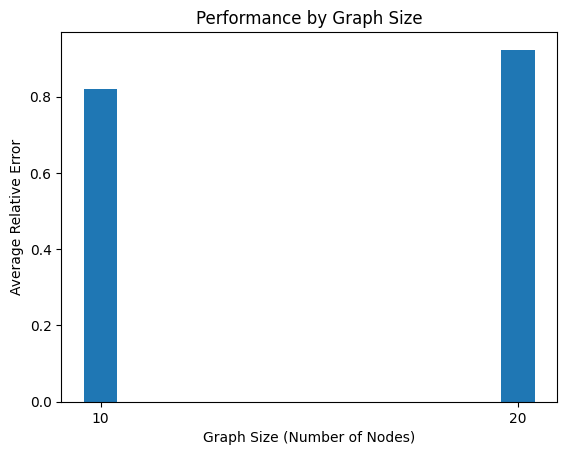

In [124]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize data structures to store relative errors by graph size
errors_by_size = defaultdict(list)  # Stores relative errors grouped by graph size

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for batch in test_loader:
        # Extract data from the batch
        batch_graph = batch.to(device)
        coordinates = batch_graph.x
        edge_index_optimal = batch_graph.edge_index

        # Forward pass
        logits, edge_index_knn = model(coordinates)

        # Compute edge probabilities
        edge_probs = F.softmax(logits, dim=1)[:, 1]  # Probabilities for class 1 (TSP tour)

        # Threshold to filter predicted edges
        threshold = 0.000001
        mask = edge_probs > threshold
        edge_predictions = edge_index_knn[:, mask]

        # Validate the predicted tour
        city_coordinates = coordinates.cpu().numpy()
        try:
            num_nodes = city_coordinates.shape[0]  # Get the graph size (number of nodes)
            tour_edges_predicted = validate_and_construct_tour(edge_predictions, num_nodes)
            
            # Calculate optimal and predicted tour lengths
            optimal_length = calculate_tour_length(coordinates, edge_index_optimal)
            predicted_length = calculate_tour_length(coordinates, tour_edges_predicted)
            
            # Compute relative error
            relative_error = abs(predicted_length - optimal_length) / optimal_length
            errors_by_size[num_nodes].append(relative_error)
        
        except ValueError as e:
            # Skip this graph if a valid tour could not be constructed
            print(f"Skipping graph due to error in constructing tour: {e}")
            continue

# Calculate statistics for each graph size
statistics_by_size = {
    size: {
        "average_error": sum(errors) / len(errors),
        "max_error": max(errors),
        "min_error": min(errors),
        "num_graphs": len(errors)
    }
    for size, errors in errors_by_size.items()
}

# Display statistics
print("Statistics by Graph Size:")
for size, stats in statistics_by_size.items():
    print(f"Graph Size: {size}")
    print(f"  Number of Graphs: {stats['num_graphs']}")
    print(f"  Average Relative Error: {stats['average_error']:.4f}")
    print(f"  Max Relative Error: {stats['max_error']:.4f}")
    print(f"  Min Relative Error: {stats['min_error']:.4f}")
    print()

# Plot average relative error by graph size
graph_sizes = list(statistics_by_size.keys())
average_errors = [stats["average_error"] for stats in statistics_by_size.values()]

plt.bar(graph_sizes, average_errors)
plt.xlabel('Graph Size (Number of Nodes)')
plt.ylabel('Average Relative Error')
plt.title('Performance by Graph Size')
plt.xticks(graph_sizes)
plt.show()
